In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedGroupKFold,
    GroupKFold,
    StratifiedKFold,
)

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../Data/merged_cleaned.csv',
                 index_col= [0],
                 parse_dates= [0])



In [4]:
df_feat_1 = df[['Gesamt (Netzlast) [MWh] Berechnete Auflösungen','Deutschland/Luxemburg [€/MWh] Originalauflösungen',
                'hour_sin','dayofweek_sin','month_sin','dayofyear_sin']]
df_load = df_feat_1.iloc[:, [0]]

Train test split

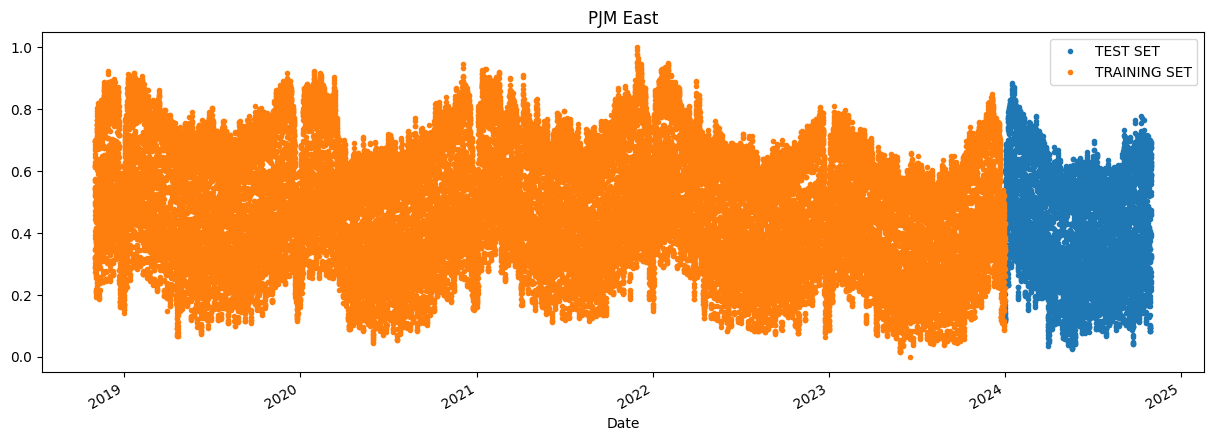

In [5]:
split_date = '01.01.2024'
train = df_load.loc[df_load.index <= split_date].copy()
test = df_load.loc[df_load.index > split_date].copy()

# Plot train and test so you can see where we have split
test \
    .rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TEST SET'}) \
    .join(train.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TRAINING SET'}), 
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()


## Simple Prohphet model

In [6]:
train_prophet = train.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

In [7]:
%%time
model = Prophet()
model.fit(train_prophet)

09:34:54 - cmdstanpy - INFO - Chain [1] start processing
09:35:11 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 391 ms
Wall time: 18.9 s


In [8]:
test_prophet = test.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

test_forecast = model.predict(test_prophet)

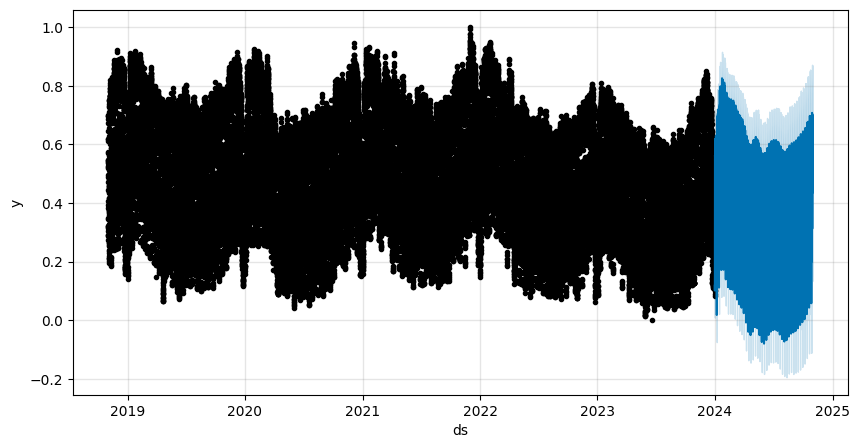

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_forecast, ax=ax)

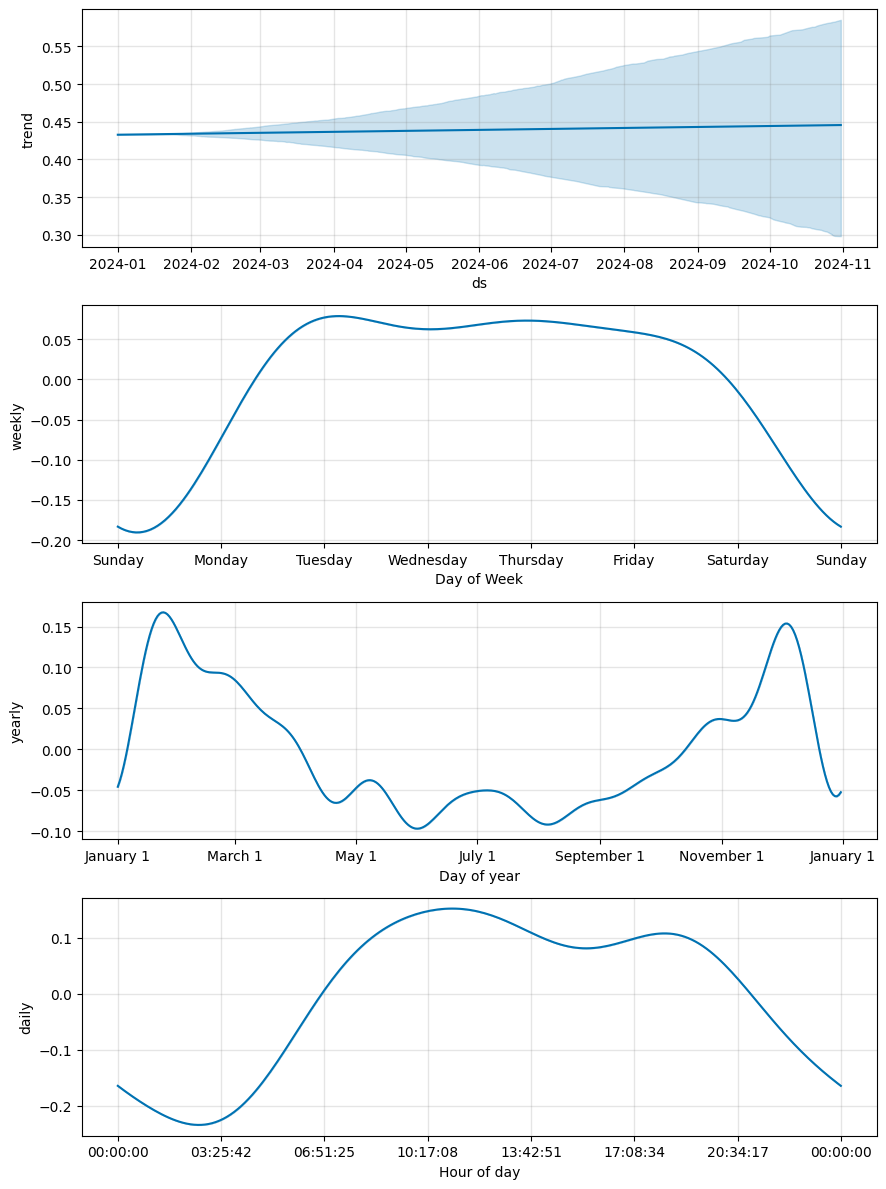

In [10]:
fig = model.plot_components(test_forecast)
plt.show()

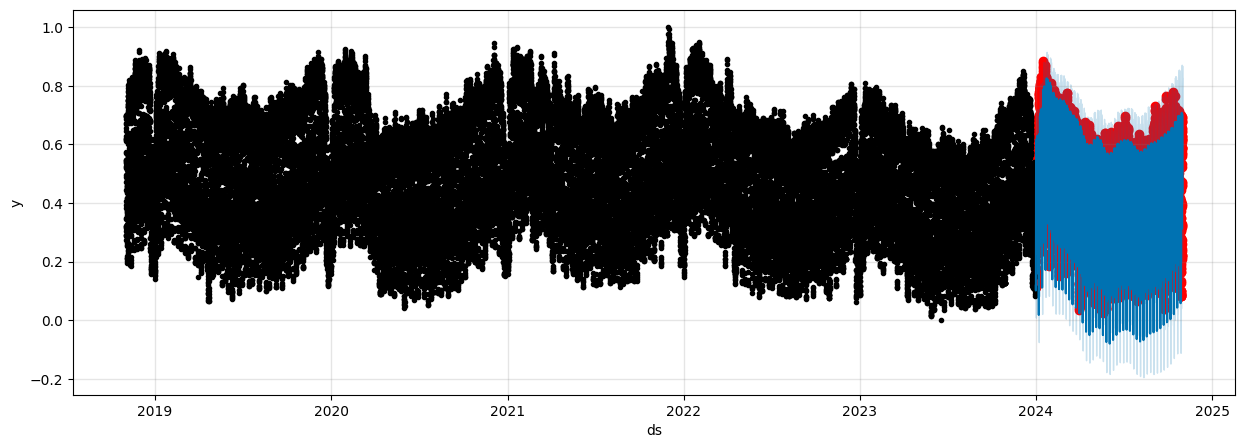

In [11]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r')
fig = model.plot(test_forecast, ax=ax)

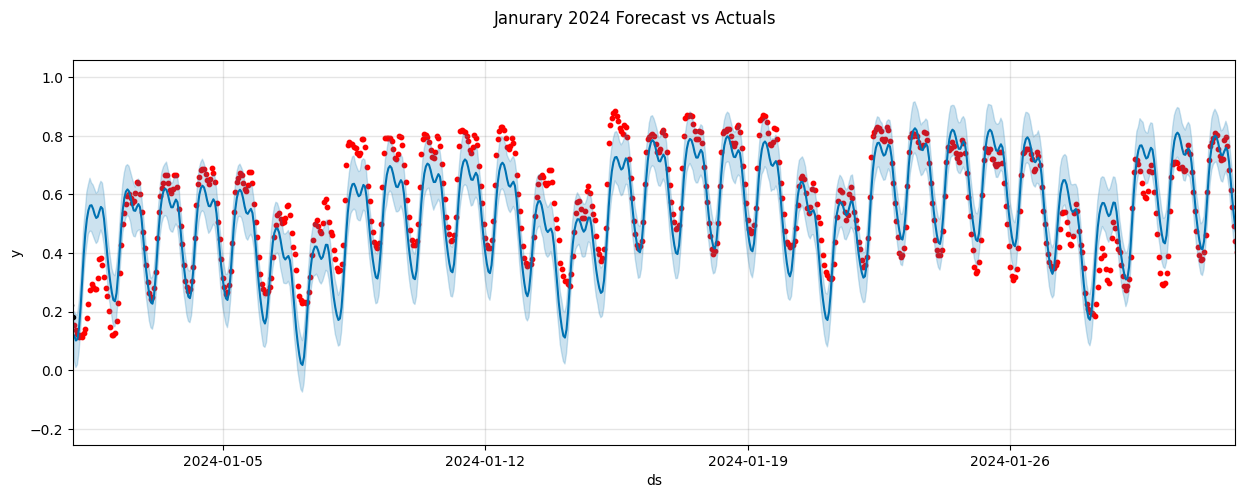

In [12]:
# Filter test data for February 2023
test_february = test.loc['2024-01-01':'2024-02-01']

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actuals (February 2023 only)
ax.scatter(test_february.index, test_february['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r', s=10)

# Plot the forecast (ensure test_forecast contains the relevant forecast for February)
fig = model.plot(test_forecast, ax=ax)

# Set the x-axis limits to February 2023
ax.set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-02-01'))

# Title of the plot
plt.suptitle('Janurary 2024 Forecast vs Actuals')

# Show the plot
plt.show()


In [13]:
mean_absolute_percentage_error(y_true = test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], y_pred = test_forecast['yhat'])

0.1861094829847535

In [14]:
df['Holiday'].value_counts()

Holiday
Not a Holiday           51324
Christmas Day             144
Second Christmas Day      144
New year                  144
Good Friday               144
Easter Monday             144
Labour Day                144
Ascension Thursday        144
Whit Monday               144
Day of German Unity       144
Name: count, dtype: int64

In [15]:
df_feat_1 = df[['Gesamt (Netzlast) [MWh] Berechnete Auflösungen','Deutschland/Luxemburg [€/MWh] Originalauflösungen',
                'hour_sin','dayofweek_sin','month_sin','dayofyear_sin']]